In [28]:
import pandas as pd ### para manejo de datos
import sqlite3 as sql
import a_funciones as funciones  ###archivo de funciones propias
import numpy as np
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables 
import openpyxl
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.ensemble import RandomForestClassifier  # Clasificador bosques aleatoriost 
from sklearn.tree import DecisionTreeClassifier


In [29]:
df4 = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/df_fin.csv", sep=",")
df0 = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/base16.csv", sep=",")

In [30]:
df4.head(3)

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,JobInvolvement,PerformanceRating,Attrition,resignationReason
0,3,4,2,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,...,131160,1,11,0,1,6,3,3,No,NaN
1,3,2,4,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,...,41890,0,23,1,6,3,2,4,Yes,Others
2,2,2,1,32,Travel_Frequently,Research & Development,17,4,Other,Male,...,193280,1,15,3,5,2,3,3,No,NaN


## **Obtener dummies**

In [31]:
# Obtener variables dummy para las columnas categóricas excepto 'Attrition'
df_dum = pd.get_dummies(df4.drop('Attrition', axis=1))

# Añadir la variable 'Attrition' de nuevo al DataFrame
df_dum['Attrition'] = df4['Attrition']

In [34]:
# Agregar 'Attrition' de nuevo al DataFrame
df_dum['Attrition'] = df4['Attrition']

In [35]:
### conversion a entero 
df_dum['Attrition'] = df_dum['Attrition'].map({'No': 0, 'Yes': 1}).astype(int)


## **Seleccion de variables**

In [36]:
#####Separamos nuestra variable de las demas variables
X = df_dum.drop('Attrition',axis=1)
y = df_dum['Attrition']

In [37]:
######Seleccion de modelos
### 1. Regresion logistica 
m_rl = LogisticRegression()
### 2. Random forest
m_rf = RandomForestClassifier()
### 3 Arboles de decision
m_add = DecisionTreeClassifier()


In [38]:
####Modelos
modelos = list([m_rl, m_rf, m_add])

In [39]:
#####Seleccion de variables 
var_names=funciones.sel_variables(modelos,X,y,threshold="2.9*mean")
var_names.shape


(6,)

In [40]:
### matriz con variables seleccionadas
X2=X[var_names]
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   JobSatisfaction           4284 non-null   int64
 1   NumCompaniesWorked        4284 non-null   int64
 2   TotalWorkingYears         4284 non-null   int64
 3   resignationReason_Others  4284 non-null   uint8
 4   resignationReason_Salary  4284 non-null   uint8
 5   resignationReason_Stress  4284 non-null   uint8
dtypes: int64(3), uint8(3)
memory usage: 113.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   EnvironmentSatisfaction            4284 non-null   int64
 1   JobSatisfaction                    4284 non-null   int64
 2   WorkLifeBalance                    4284 non-null   int64
 3 

## **Selección de modelo**

In [42]:
## base con todas las variables
rmse_df=funciones.medir_modelos(modelos,"f1",X,y,6)  
## base con variables seleccionadas
rmse_varsel=funciones.medir_modelos(modelos,"f1",X2,y,6)

rmse=pd.concat([rmse_df,rmse_varsel],axis=1)
rmse.columns=['rl', 'rf', 'add',
       'rl_Sel', 'rf_sel', 'add_sel']




c:\Users\luisa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

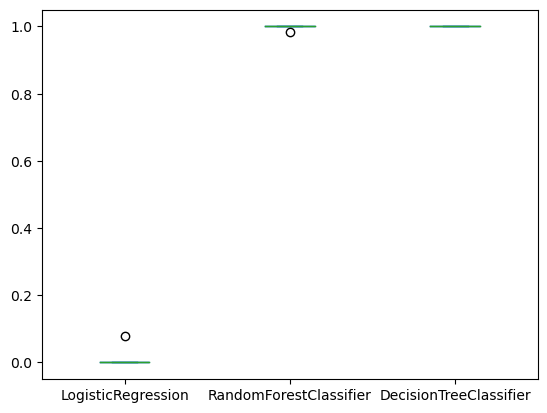

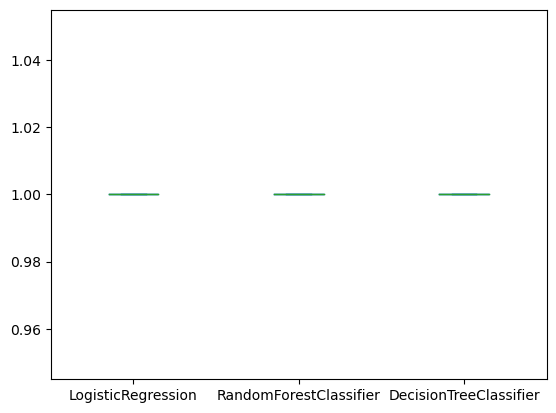

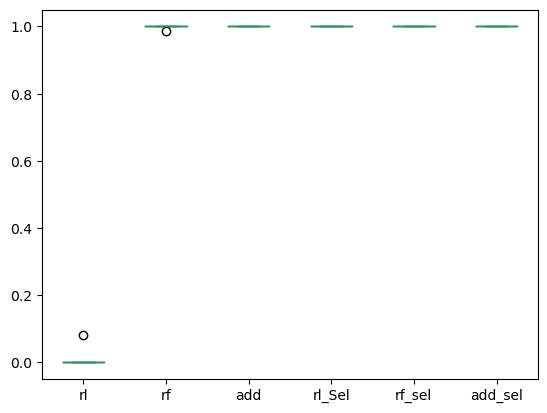

In [43]:
rmse_df.plot(kind='box') #### gráfico para modelos todas las varibles
rmse_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas
rmse.plot(kind='box') ### gráfico para modelos sel y todas las variables

rl         0.013333
rf         0.997462
add        1.000000
rl_Sel     1.000000
rf_sel     1.000000
add_sel    1.000000
dtype: float64

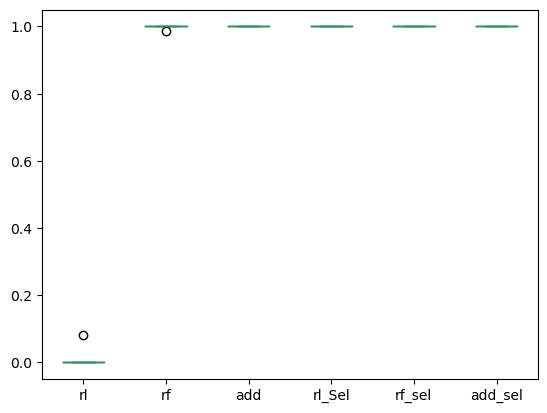

In [44]:
rmse2=rmse[ ['rl', 'rf', 'add','rl_Sel', 'rf_sel', 'add_sel']]
rmse2.plot(kind='box') ### gráfico para modelos sel y todas las variables

rmse.mean() ### medias de mape